Changelog
- 3 Oct
    - Creation
    - Add `Tables`, `DataValueInterfaces` and `DataAPI` because `PGFPlots` wasn't getting precompiled
    - Wrote functions for regressogram,local_averaging and Gaussian kernel regression
    - Works fine on Glass. Regressogram not working on motorcycle dataset

In [97]:
# Imports
using DelimitedFiles # To use readdlm
using PGFPlots
using StatsBase # To use mean

#### function definitions

In [69]:
# function: make even bins
"""
    function make_bins(num_bins,lo,hi)
- Make `num_bins` even bins from `lo` to `hi`

# Example
```julia
bin_lefts = make_bins(10,0.29,3.50)
```
"""
function make_bins(num_bins,lo,hi;verbosity=false)
    bin_array = fill(0.,num_bins)
    if verbosity print("lo=$lo,hi=$hi,num_bins=$num_bins\n") end
    width = (hi-lo)/num_bins
    if verbosity print("width=$width\n") end
    for i in 1:num_bins
        bin_array[i] = lo+width*(i-1)
    end
    return bin_array
end

# function: Create dict with bins and corresponding average outputs
"""
    function binned_y_average(binned_y_train)
- Given a dict with bin number as keys and array of output values as value
- Return dict with same bin number keys but just the corresponding mean value

# Example
```julia
binavg_y_train = binned_y_average(binned_y_train)
```
"""
function binned_y_average(binned_y_train)
    binavg_y_train = Dict{Int64,Float64}()
    for (k,v) in binned_y_train
        binavg_y_train[k] = mean(v)
    end
    return binavg_y_train
end

make_bins

In [79]:
# Read in the glass dataset


In [144]:
# function: Regressogram
"""
    function regressogram(num_bins,lo,hi,num_test)
- Divide input (covariate) range into `num_bins` from `lo` to `hi`
- Run regressogram on `num_test` evenly spaced input points in the range `lo` to `hi`
- Training is done using `x_train` and `y_train`

# How it works
- Collect training data input values into uniform bins
- Caculate corresponding average y value
- Test input is placed into bin and associated output is average computed above

# Examples
```julia
g = readdlm("glass.dat");y_train = Float64.(a[2:end,2]);x_train=Float64.(a[2:end,5]);
p_regressogram = regressogram(10,0.29,3.50,200,x_train,y_train)
```
"""
function regressogram(num_bins,lo,hi,num_test,x_train,y_train)
    bin_lefts = make_bins(num_bins,lo,hi);

    binned_y_train = Dict{Int64,Array{Float64,1}}()
    binned_x_train = Dict{Int64,Array{Float64,1}}()
    # initialize the dictionary
    for i in 1:num_bins
        binned_y_train[i] = []
        binned_x_train[i] = []
    end
    # Go over the training set and push the y values into bins to take mean later
    for (j,x_train_sample) in enumerate(x_train)
        push!(binned_y_train[argmin(abs.(x_train_sample .- bin_lefts))],y_train[j])
        push!(binned_x_train[argmin(abs.(x_train_sample .- bin_lefts))],x_train_sample)
    end
    binavg_y_train = binned_y_average(binned_y_train)
    
    x_test = make_bins(num_test,lo,hi);
    y_test = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        y_test[i] = binavg_y_train[argmin(abs.(x_test_sample .- bin_lefts))]
    end
    plot_regressogram = PGFPlots.Plots.Scatter(x_test,y_test,legendentry="Regressogram");
    return plot_regressogram
end

regressogram

In [148]:
# function: local_averaging
"""
    function local_averaging(bandwidth,lo,hi,num_test,x_train,y_train)
`lo` and `hi` are used to create `num_test` test points. They don't directly work in the algo

# How it works
- For every test input, consider the training inputs within `bandwidth` from the test input
- The associated test output is the average training outputs of these points within the bandwidth

# Examples
```julia
p_lavg = local_averaging(0.321,0.29,3.50,200,x_train,y_train)
```
"""
function local_averaging(bandwidth,lo,hi,num_test,x_train,y_train)
    x_test = make_bins(num_test,lo,hi)
    y_test_localavg = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        x_neighbors = []
        y_neighbors = []
        for (kk,x_train_sample) in enumerate(x_train)
            if abs(x_train_sample-x_test_sample) <= bandwidth
                push!(x_neighbors,x_train_sample)
                push!(y_neighbors,y_train[kk])
            end
        end
        y_test_localavg[i] = mean(y_neighbors)
    end
    plot_localavg = PGFPlots.Plots.Scatter(x_test,y_test_localavg,legendentry="Local Averaging");
    return plot_localavg
end

local_averaging

In [149]:
# function: Gaussian Kernel
"""
    function gaussian_kernel(bandwidth,lo,hi,num_test,x_train,y_train)

# How it works
- For every test input, assign weights to all the training points
- These weights determine how much every training point contributes to the test output
- The weights is calculated based on the Gaussian pdf form of distance calculator

# Examples
```julia
p_gauss = gaussian_kernel(0.321,0.29,3.50,200,x_train,y_train)
```
"""
function gaussian_kernel(bandwidth,lo,hi,num_test,x_train,y_train)
    x_test = make_bins(num_test,lo,hi)
    y_test_gaussian = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        weights = fill(0.,length(x_train),)

        for (kk,x_train_sample) in enumerate(x_train)
            weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bandwidth)^2)
        end
        y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
    end
    plot_gaussian = PGFPlots.Plots.Scatter(x_test,y_test_gaussian,legendentry="Gaussian Kernel");
    return plot_gaussian
end

gaussian_kernel

#### glass dataset

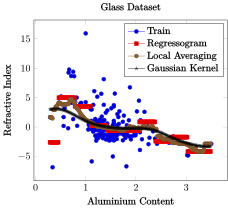

In [152]:
# Compare various regressions for glass dataset
g = readdlm("glass.dat");y_train = Float64.(g[2:end,2]);x_train=Float64.(g[2:end,5]);
plot_trainingdata = PGFPlots.Plots.Scatter(x_train,y_train,legendentry="Train");
num_bins = 10; lo=0.29;hi=3.50;num_test=200;bandwidth=0.321;
p_regressogram = regressogram(num_bins,lo,hi,num_test,x_train,y_train)
p_lavg = local_averaging(bandwidth,lo,hi,num_test,x_train,y_train)
p_gauss = gaussian_kernel(bandwidth,lo,hi,num_test,x_train,y_train)
PGFPlots.Axis([plot_trainingdata,p_reg,p_lavg,p_gauss],title="Glass Dataset",
    xlabel="Aluminium Content",ylabel="Refractive Index")

#### motorcycle dataset

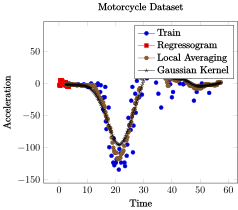

In [156]:
m = readdlm("motor.dat"); y_train_motor = Float64.(m[2:end,2]); x_train_motor = Float64.(m[2:end,1]);
plot_trainingdata = PGFPlots.Plots.Scatter(x_train_motor,y_train_motor,legendentry="Train");
num_bins = 20; lo_m=2.4;hi_m=57.6;num_test=200;bandwidth=2.76;
p_regressogram = regressogram(num_bins,lo_m,hi_m,num_test,x_train_motor,y_train_motor)
p_lavg = local_averaging(bandwidth,lo,hi,num_test,x_train_motor,y_train_motor)
p_gauss = gaussian_kernel(bandwidth,lo,hi,num_test,x_train_motor,y_train_motor)
PGFPlots.Axis([plot_trainingdata,p_reg,p_lavg,p_gauss],title="Motorcycle Dataset",
    xlabel="Time",ylabel="Acceleration")